In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from google.colab import files
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)))

Saving train.csv to train.csv


In [ ]:
#Sorting by Customer ID and Time
df = df.sort_values(by=['CUSTOMER_ID', 'TX_DATETIME']).reset_index(drop=True)
print(df)

        TRANSACTION_ID          TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  \
0                59452  2021-08-01 03:01:00            0         1133   
1                59592  2021-08-01 05:30:38            0         1138   
2                60132  2021-08-01 10:40:12            0         1530   
3                60721  2021-08-01 15:38:25            0          241   
4                61033  2021-08-01 19:25:30            0         1536   
...                ...                  ...          ...          ...   
291226          340089  2021-12-25 12:28:15          999          753   
291227          340221  2021-12-25 13:30:51          999          119   
291228          340572  2021-12-25 16:24:28          999          753   
291229          346150  2021-12-28 14:14:27          999          959   
291230          346890  2021-12-29 03:29:48          999         1181   

        TX_AMOUNT  TX_FRAUD  
0           61.51         0  
1          129.61         0  
2           96.50         0  
3  

In [ ]:
scaler = StandardScaler()

def scale_features(df):
    features_to_scale = ['TX_AMOUNT', 'time_since_last_tx', 'avg_same_day_amount', 'avg_tx_amount_last3']
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    return df


In [ ]:
fraud_counts = df['TX_FRAUD'].value_counts().map({0: 'Non-Fraud', 1: 'Fraud'})
print(fraud_counts)

TX_FRAUD
0    NaN
1    NaN
Name: count, dtype: object


In [ ]:
from sklearn.utils import resample

def undersample_data(X, y):
    # Concatenate X and y to combine them into one DataFrame
    df = pd.concat([X, y], axis=1)

    # Separate the majority and minority classes
    df_majority = df[df['TX_FRAUD'] == 0]
    df_minority = df[df['TX_FRAUD'] == 1]

    # Undersample the majority class
    df_majority_undersampled = resample(df_majority,
                                        replace=False,
                                        n_samples=len(df_minority),
                                        random_state=42)

    # Combine the undersampled majority class with the minority class
    df_undersampled = pd.concat([df_majority_undersampled, df_minority])

    # Shuffle the dataset to mix the classes
    df_undersampled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the data back into X and y
    X_undersampled = df_undersampled.drop(columns=['TX_FRAUD'])
    y_undersampled = df_undersampled['TX_FRAUD']

    return X_undersampled, y_undersampled

In [ ]:
# Convert datetime
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Sort to respect time per customer
df = df.sort_values(by=['CUSTOMER_ID', 'TX_DATETIME']).reset_index(drop=True)


# Extracting important features pertaining to time
df['time_since_last_tx'] = df.groupby('CUSTOMER_ID')['TX_DATETIME'].diff().dt.total_seconds()
df['time_since_last_tx'] = df['time_since_last_tx'].fillna(0)
df['avg_tx_amount_last3'] = (
    df.groupby('CUSTOMER_ID')['TX_AMOUNT']
    .rolling(window=3, min_periods=1).mean()
    .reset_index(level=0, drop=True)
)
df['TX_DATE'] = df['TX_DATETIME'].dt.date
df['avg_same_day_amount'] = (
    df.groupby(['CUSTOMER_ID', 'TX_DATE'])['TX_AMOUNT']
    .transform('mean')
)

df = scale_features(df)

# Temporal train-test split
split_time = df['TX_DATETIME'].quantile(0.8)
train_df = df[df['TX_DATETIME'] <= split_time]
test_df = df[df['TX_DATETIME'] > split_time]

X_train = train_df.drop(columns=['TRANSACTION_ID', 'CUSTOMER_ID', 'TX_DATE', 'TX_DATETIME', 'TERMINAL_ID', 'TX_FRAUD'])
y_train = train_df['TX_FRAUD']
X_test = test_df.drop(columns=['TRANSACTION_ID', 'CUSTOMER_ID', 'TX_DATE', 'TX_DATETIME', 'TERMINAL_ID', 'TX_FRAUD'])
y_test = test_df['TX_FRAUD']

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

#X_resampled, y_resampled = undersample_data(X_train, y_train)


 Model: XGB CLassifier


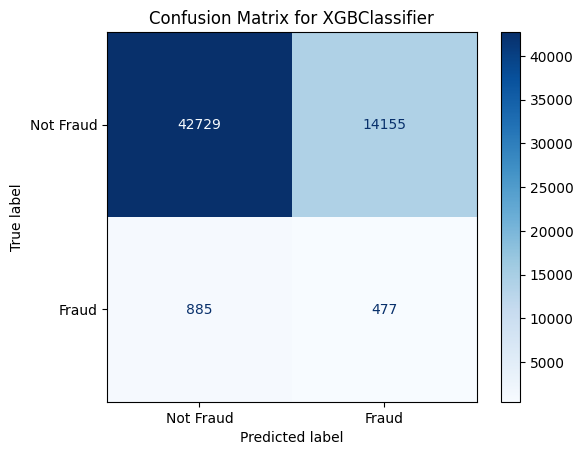


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     56884
           1       0.03      0.35      0.06      1362

    accuracy                           0.74     58246
   macro avg       0.51      0.55      0.45     58246
weighted avg       0.96      0.74      0.83     58246


 Model: LGBM Classifier
[LightGBM] [Info] Number of positive: 227765, number of negative: 227765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 455530, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


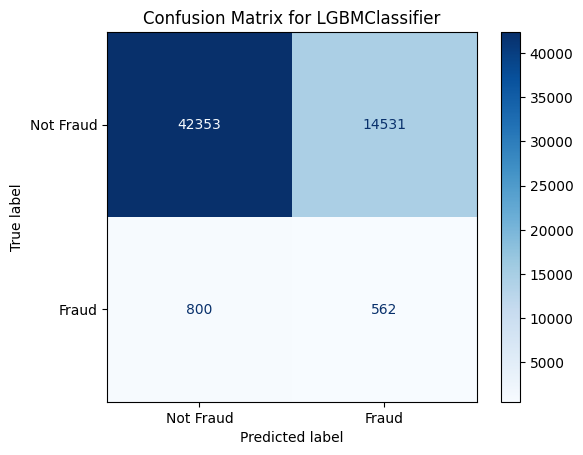


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.85     56884
           1       0.04      0.41      0.07      1362

    accuracy                           0.74     58246
   macro avg       0.51      0.58      0.46     58246
weighted avg       0.96      0.74      0.83     58246


 Model: Logistic Regression


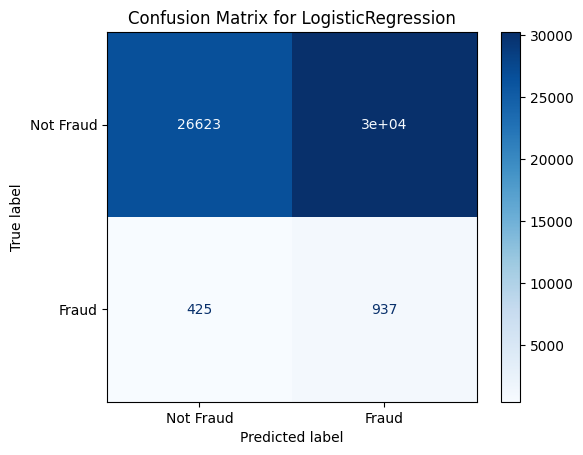


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.47      0.63     56884
           1       0.03      0.69      0.06      1362

    accuracy                           0.47     58246
   macro avg       0.51      0.58      0.35     58246
weighted avg       0.96      0.47      0.62     58246


 Model: Random Forest


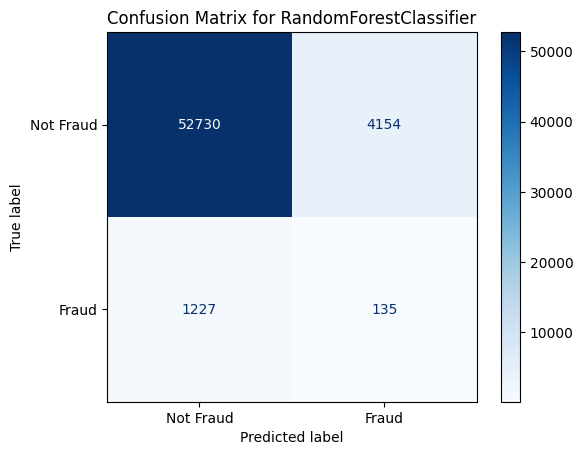


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     56884
           1       0.03      0.10      0.05      1362

    accuracy                           0.91     58246
   macro avg       0.50      0.51      0.50     58246
weighted avg       0.96      0.91      0.93     58246



In [ ]:
def run_models(df, models):

    for name, model in models.items():
        print(f"\n Model: {name}")
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
        cm_display.plot(cmap='Blues')
        plt.title(f"Confusion Matrix for {model.__class__.__name__}")
        plt.show()

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

models = {
    'XGB CLassifier': XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss'),
    'LGBM Classifier': lgb.LGBMClassifier(n_estimators=200, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

run_models(df, models)